
Linear Regression Results:
RMSE: 3.85
R2 Score: 0.80

Random Forest Results:
RMSE: 4.72
R2 Score: 0.70

XGBoost Results:
RMSE: 10.13
R2 Score: -0.40


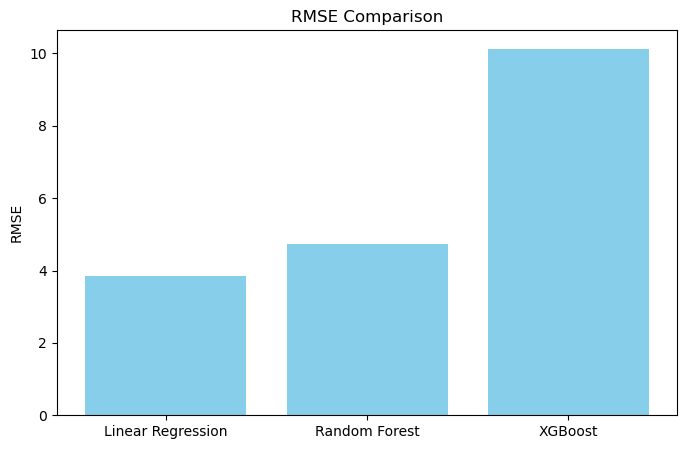

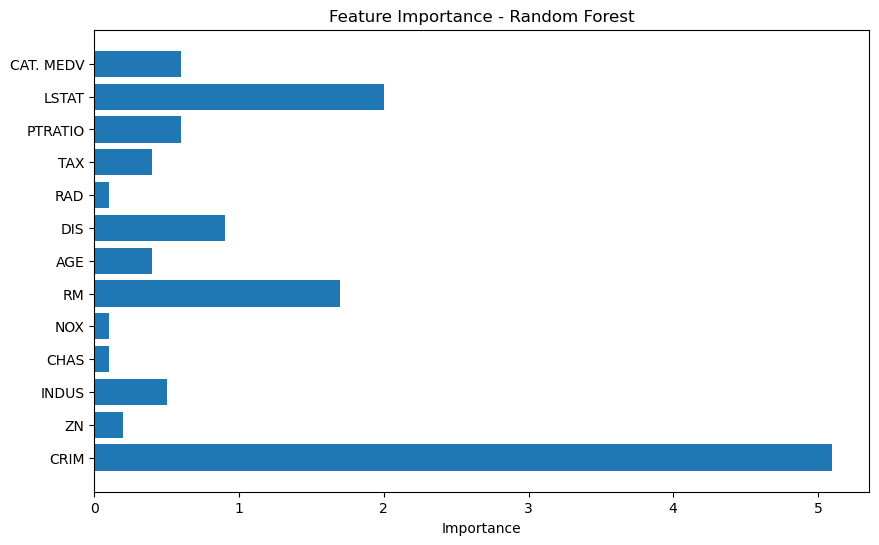

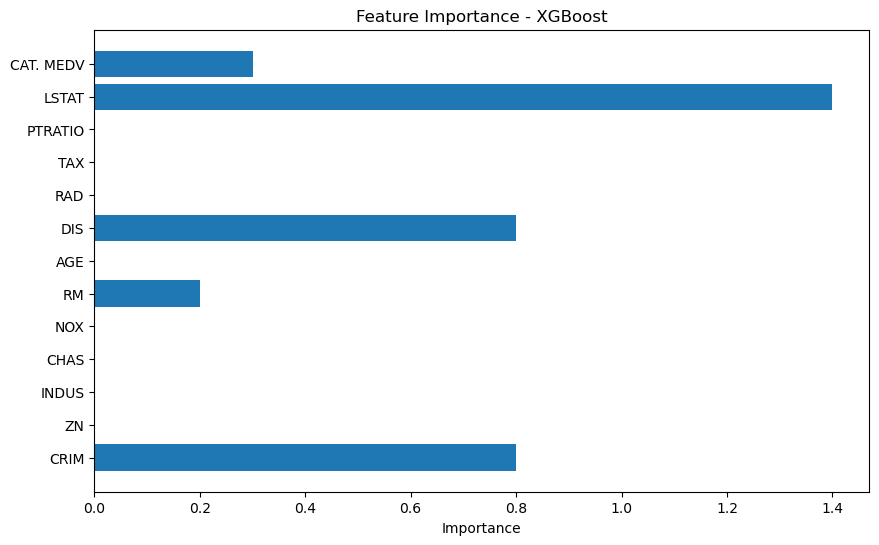

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load Dataset
df = pd.read_csv("BostonHousing.csv")

# Separate features and target
X = df.drop('MEDV', axis=1).values
y = df['MEDV'].values
feature_names = df.drop('MEDV', axis=1).columns

# Normalize the features
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# Linear Regression from Scratch
# -----------------------------
class LinearRegressionScratch:
    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        self.theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.theta)

# -----------------------------
# Decision Tree from Scratch
# -----------------------------
class DecisionTreeScratch:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.feature_importances_ = np.zeros(X_train.shape[1])

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        if depth == self.max_depth or len(set(y)) == 1:
            return np.mean(y)
        best_feat, best_thresh = self._best_split(X, y)
        if best_feat is None:
            return np.mean(y)
        self.feature_importances_[best_feat] += 1
        left_idx = X[:, best_feat] < best_thresh
        right_idx = ~left_idx
        left = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._build_tree(X[right_idx], y[right_idx], depth + 1)
        return (best_feat, best_thresh, left, right)

    def _best_split(self, X, y):
        best_feat, best_thresh, best_loss = None, None, float('inf')
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for thresh in thresholds:
                left_idx = X[:, feature] < thresh
                right_idx = ~left_idx
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                loss = self._mse(y[left_idx]) + self._mse(y[right_idx])
                if loss < best_loss:
                    best_feat, best_thresh, best_loss = feature, thresh, loss
        return best_feat, best_thresh

    def _mse(self, y):
        return np.mean((y - np.mean(y))**2)

    def _predict_sample(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, thresh, left, right = node
        if x[feature] < thresh:
            return self._predict_sample(x, left)
        else:
            return self._predict_sample(x, right)

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])

# -----------------------------
# Random Forest from Scratch
# -----------------------------
class RandomForestScratch:
    def __init__(self, n_estimators=10, max_depth=5):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        self.feature_importances_ = np.zeros(X.shape[1])
        for _ in range(self.n_estimators):
            idxs = np.random.choice(len(X), len(X), replace=True)
            tree = DecisionTreeScratch(max_depth=self.max_depth)
            tree.fit(X[idxs], y[idxs])
            self.trees.append(tree)
            self.feature_importances_ += tree.feature_importances_
        self.feature_importances_ /= self.n_estimators

    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(preds, axis=0)

# -----------------------------
# XGBoost Simplified from Scratch
# -----------------------------
class XGBoostScratch:
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        y_pred = np.zeros(len(y))
        self.trees = []
        self.feature_importances_ = np.zeros(X.shape[1])
        for _ in range(self.n_estimators):
            residuals = y - y_pred
            tree = DecisionTreeScratch(max_depth=self.max_depth)
            tree.fit(X, residuals)
            update = tree.predict(X)
            y_pred += self.learning_rate * update
            self.trees.append(tree)
            self.feature_importances_ += tree.feature_importances_
        self.feature_importances_ /= self.n_estimators

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

# -----------------------------
# Train and Evaluate Models
# -----------------------------
models = {
    'Linear Regression': LinearRegressionScratch(),
    'Random Forest': RandomForestScratch(n_estimators=10, max_depth=5),
    'XGBoost': XGBoostScratch(n_estimators=10, learning_rate=0.1, max_depth=3)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"\n{name} Results:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")

# -----------------------------
# Plot RMSE Comparison
# -----------------------------
labels, rmse_values = zip(*[(k, v['RMSE']) for k, v in results.items()])
plt.figure(figsize=(8, 5))
plt.bar(labels, rmse_values, color='skyblue')
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.show()

# -----------------------------
# Feature Importance Plot
# -----------------------------
def plot_feature_importance(model, model_name):
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
        plt.figure(figsize=(10, 6))
        plt.barh(feature_names, importance)
        plt.xlabel("Importance")
        plt.title(f"Feature Importance - {model_name}")
        plt.show()

# Plot for tree-based models
plot_feature_importance(models["Random Forest"], "Random Forest")
plot_feature_importance(models["XGBoost"], "XGBoost")
